In [1]:
import pandas as pd

df = pd.read_csv('cleaned_data.csv')
df.head()

datetime      city  humidity  pressure  temperature  wind_speed  \
0  2017-01-01 00:00:00  Portland      96.0    1017.0       35.582         3.0   
1  2017-01-01 01:00:00  Portland      96.0    1016.0       35.852         2.0   
2  2017-01-01 02:00:00  Portland      99.0    1015.0       35.600         3.0   
3  2017-01-01 03:00:00  Portland      99.0    1014.0       35.312         2.0   
4  2017-01-01 04:00:00  Portland      99.0    1013.0       34.826         1.0   

   wind_direction   latitude   longitude weather  
0           160.0  45.523449 -122.676208   foggy  
1           200.0  45.523449 -122.676208   rainy  
2           221.0  45.523449 -122.676208   foggy  
3           170.0  45.523449 -122.676208   rainy  
4           210.0  45.523449 -122.676208   rainy

In [2]:
df.shape

(213435, 10)

In [3]:
df.describe()

humidity       pressure    temperature     wind_speed  \
count  213435.000000  213435.000000  213435.000000  213435.000000   
mean       65.625121    1015.650315      62.116792       3.103718   
std        23.499457      11.533889      17.303049       2.056707   
min         5.000000     801.000000     -12.082000       0.000000   
25%        49.000000    1012.000000      50.756000       2.000000   
50%        69.000000    1016.000000      63.824000       3.000000   
75%        86.000000    1020.000000      74.750000       4.000000   
max       100.000000    1046.000000     118.400000      35.000000   

       wind_direction       latitude      longitude  
count   213435.000000  213435.000000  213435.000000  
mean       183.671296      37.266939     -95.642412  
std        102.718588       5.218846      15.963697  
min          0.000000      25.774269    -122.676208  
25%        100.000000      33.448380    -112.074043  
50%        190.000000      37.774929     -93.263840  
75%        270.000000      40.714272     -81.655647  
max        360.000000      47.606209     -71.059769

# K-Means

In [4]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np

In [5]:
# Filter data for snowy weather
snowy_data = df[df['weather'] == 'snowy']

# Calculate snowy weather count per city
snowy_weather_per_city = snowy_data.groupby('city').size().reset_index(name='snowy_weather_count')

# Calculate average weather metrics for snowy weather per city
snowy_weather_metrics = snowy_data.groupby('city').agg({
    'temperature': 'mean',
    'humidity': 'mean',
    'pressure': 'mean',
    'wind_speed': 'mean',
    'wind_direction': 'mean'
}).reset_index()

# Merging snowy weather count and average weather metrics per city
snowy_weather_per_city = snowy_weather_per_city.merge(snowy_weather_metrics, on='city')

# Adding latitude and longitude
snowy_weather_per_city = snowy_weather_per_city.merge(df[['city', 'latitude', 'longitude']].drop_duplicates(), on='city')

# Reordering columns for better readability
snowy_weather_per_city = snowy_weather_per_city[['city', 'latitude', 'longitude', 'snowy_weather_count', 'temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction']]

# Display the DataFrame
snowy_weather_per_city

city   latitude   longitude  snowy_weather_count  temperature  \
0     Albuquerque  35.084492 -106.651138                   25    34.252160   
1         Atlanta  33.749001  -84.387978                   20    33.061100   
2          Boston  42.358429  -71.059769                  116    27.990034   
3       Charlotte  35.227089  -80.843132                    4    31.968500   
4         Chicago  41.850029  -87.650047                  150    32.173684   
5          Dallas  32.783058  -96.806671                   10    24.294200   
6          Denver  39.739151 -104.984703                  134    26.486358   
7         Detroit  42.331429  -83.045753                  270    26.858910   
8         Houston  29.763281  -95.363274                    1    37.562000   
9    Indianapolis  39.768379  -86.158043                   76    27.815772   
10    Kansas City  39.099731  -94.578568                   34    25.382882   
11    Minneapolis  44.979969  -93.263840                  255    25.476645   
12      Nashville  36.165890  -86.784439                    8    24.440000   
13       New York  40.714272  -74.005966                   95    27.697432   
14   Philadelphia  39.952339  -75.163788                   76    30.329553   
15     Pittsburgh  40.440620  -79.995888                  282    25.419558   
16       Portland  45.523449 -122.676208                   18    32.788000   
17    Saint Louis  38.627270  -90.197891                   43    26.605442   
18  San Francisco  37.774929 -122.419418                    1    33.944000   
19        Seattle  47.606209 -122.332069                   43    35.083023   

     humidity     pressure  wind_speed  wind_direction  
0   79.600000  1010.120000    4.600000      202.240000  
1   67.700000  1021.250000    3.950000      316.900000  
2   78.293103  1016.241379    5.448276      210.017241  
3   89.750000  1015.500000    3.750000      100.000000  
4   79.786667  1015.360000    5.006667      238.633333  
5   63.800000  1027.000000    6.500000      252.000000  
6   79.701493  1016.559701    2.417910      162.611940  
7   70.092593  1014.870370    4.555556      244.659259  
8   75.000000  1017.000000    3.000000      340.000000  
9   78.736842  1017.802632    5.434211      262.960526  
10  67.117647  1021.294118    3.764706      247.852941  
11  75.145098  1013.858824    4.905882      214.682353  
12  68.875000  1022.750000    3.750000      321.250000  
13  59.252632  1016.947368    5.357895      256.252632  
14  66.000000  1010.671053    4.565789      245.328947  
15  66.446809  1017.457447    5.156028      271.248227  
16  73.555556  1012.611111    4.333333      134.444444  
17  72.209302  1021.348837    4.767442      295.465116  
18  68.000000  1022.000000    6.000000      360.000000  
19  90.232558  1008.581395    3.069767      148.372093

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

weather_features = ['temperature', 'humidity', 'pressure', 'wind_speed', 'wind_direction', 'snowy_weather_count']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(snowy_weather_per_city[weather_features])

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

In [8]:
# Concatenate PCA components with snowy_weather_per_city DataFrame
pca_df = pd.concat([snowy_weather_per_city, pd.DataFrame(X_pca, columns=['pca1', 'pca2', 'pca3'])], axis=1)

# Display the DataFrame
pca_df.head()

city   latitude   longitude  snowy_weather_count  temperature  \
0  Albuquerque  35.084492 -106.651138                   25    34.252160   
1      Atlanta  33.749001  -84.387978                   20    33.061100   
2       Boston  42.358429  -71.059769                  116    27.990034   
3    Charlotte  35.227089  -80.843132                    4    31.968500   
4      Chicago  41.850029  -87.650047                  150    32.173684   

    humidity     pressure  wind_speed  wind_direction      pca1      pca2  \
0  79.600000  1010.120000    4.600000      202.240000  0.533697 -0.080608   
1  67.700000  1021.250000    3.950000      316.900000 -0.059335 -0.479586   
2  78.293103  1016.241379    5.448276      210.017241 -0.026748  0.207746   
3  89.750000  1015.500000    3.750000      100.000000  0.721978  0.023903   
4  79.786667  1015.360000    5.006667      238.633333  0.149929  0.175655   

       pca3  
0 -0.163275  
1 -0.132562  
2  0.034201  
3  0.382584  
4 -0.237260

In [10]:
# rearranging columns
pca_df.columns = ['city', 'latitude', 'longitude', 'snowy_weather_count', 'avg_temperature', 'avg_humidity', 'avg_pressure', 'avg_wind_speed', 'avg_wind_direction', 'pca1', 'pca2', 'pca3']
pca_df.head()

city   latitude   longitude  snowy_weather_count  avg_temperature  \
0  Albuquerque  35.084492 -106.651138                   25        34.252160   
1      Atlanta  33.749001  -84.387978                   20        33.061100   
2       Boston  42.358429  -71.059769                  116        27.990034   
3    Charlotte  35.227089  -80.843132                    4        31.968500   
4      Chicago  41.850029  -87.650047                  150        32.173684   

   avg_humidity  avg_pressure  avg_wind_speed  avg_wind_direction      pca1  \
0     79.600000   1010.120000        4.600000          202.240000  0.533697   
1     67.700000   1021.250000        3.950000          316.900000 -0.059335   
2     78.293103   1016.241379        5.448276          210.017241 -0.026748   
3     89.750000   1015.500000        3.750000          100.000000  0.721978   
4     79.786667   1015.360000        5.006667          238.633333  0.149929   

       pca2      pca3  
0 -0.080608 -0.163275  
1 -0.479586 -0.132562  
2  0.207746  0.034201  
3  0.023903  0.382584  
4  0.175655 -0.237260

In [11]:
pca_df.to_csv('clusteringdata.csv', index = False)

In [12]:
features = pca_df[['pca1', 'pca2', 'pca3']]
features.head()

pca1      pca2      pca3
0  0.533697 -0.080608 -0.163275
1 -0.059335 -0.479586 -0.132562
2 -0.026748  0.207746  0.034201
3  0.721978  0.023903  0.382584
4  0.149929  0.175655 -0.237260

In [13]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

k_values = range(2, 11)
wcss = []  
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=123)
    cluster_labels = kmeans.fit_predict(features)
    silhouette_scores.append(silhouette_score(X_pca, cluster_labels))

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Use

## Elbow Method

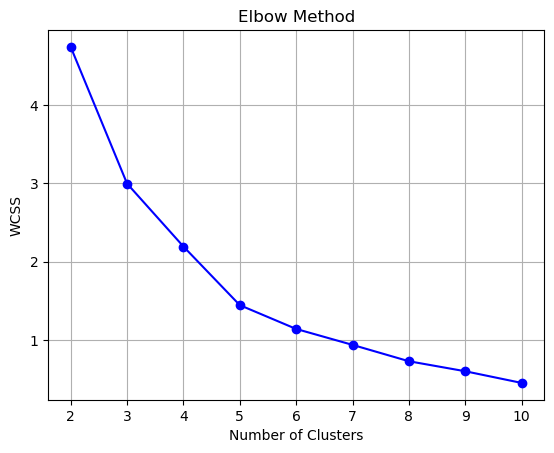

In [14]:
# Plotting Elbow Method
plt.plot(k_values, wcss, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

#### Above Elbow curve represents Inertia (WCSS) values for different number of clusters. If the Inertia value is high, then the data points in the cluster are far or not similar i.e, intra cluster distance is more.

#### From the above Elbow curve, the Elbow point is at k = 5. From Elbow point K, the rate of decrease of inertia or WCSS will not change significantly with increase in K. Therefore, optimal number of clusters using Elbow method is 5.

## Sihouette method

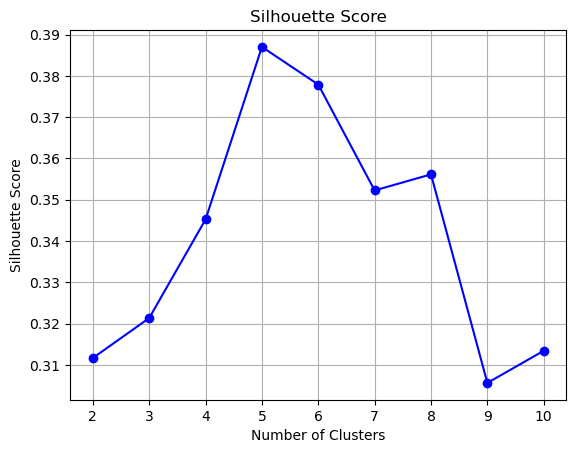

In [15]:
# Plotting Silhouette Score
plt.plot(k_values, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.grid(True)
plt.show()

#### The above plot represents Silhouette scores for different number of clusters. If the Silouette score is high, then the data points are closer to their cluster than they are to the other clusters.

#### From the above plot, Silhouette Score is maximum for k = 5 followed by k = 6 and 8. 

# KMeans with number of clusters = 5

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


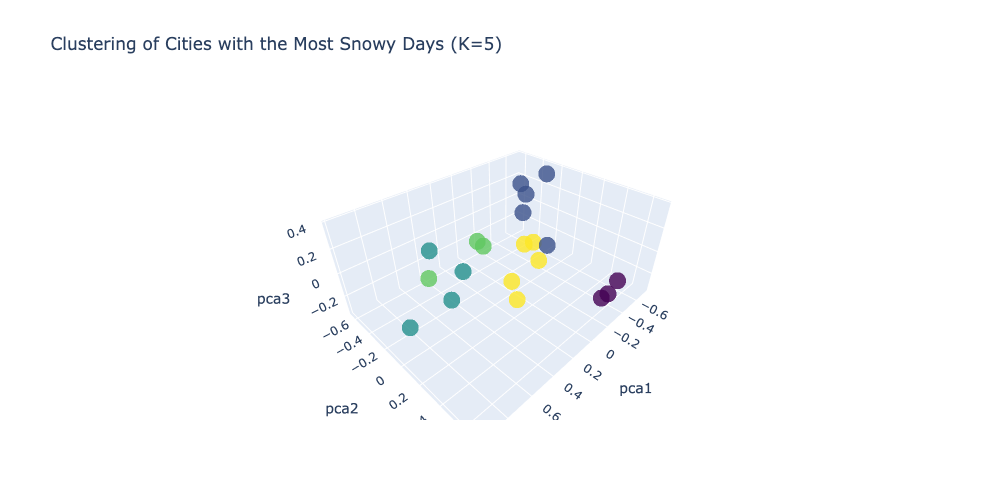

In [16]:
kmeans = KMeans(n_clusters=5)
pca_df['five_clusters'] = kmeans.fit_predict(features)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=pca_df['pca1'],
    y=pca_df['pca2'],
    z=pca_df['pca3'],
    mode='markers',
    marker=dict(
        size=10,
        color=pca_df['five_clusters'], 
        colorscale='Viridis',  
        opacity=0.8,
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='pca1',
                    yaxis_title='pca2',
                    zaxis_title='pca3'),
                  title='Clustering of Cities with the Most Snowy Days (K=5)')
fig.update_layout(height=500, width=800)
fig.show()

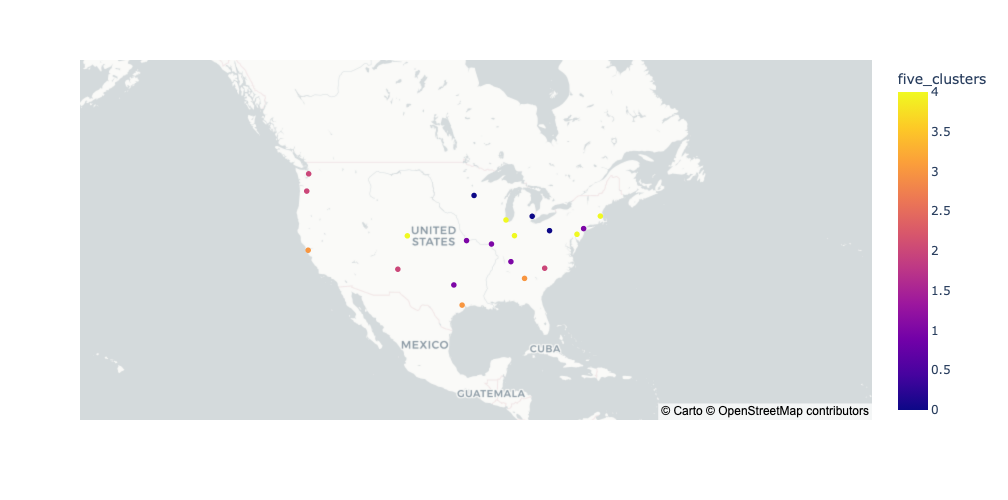

In [19]:
import plotly.express as px
hover_data_columns = list(pca_df.columns)
fig = px.scatter_mapbox(pca_df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="five_clusters",
                        hover_name="city",
                        hover_data=hover_data_columns, 
                        mapbox_style="carto-positron",
                        zoom=2)
fig.update_layout(height=500, width=800)
fig.show()

# KMeans with number of clusters = 6

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



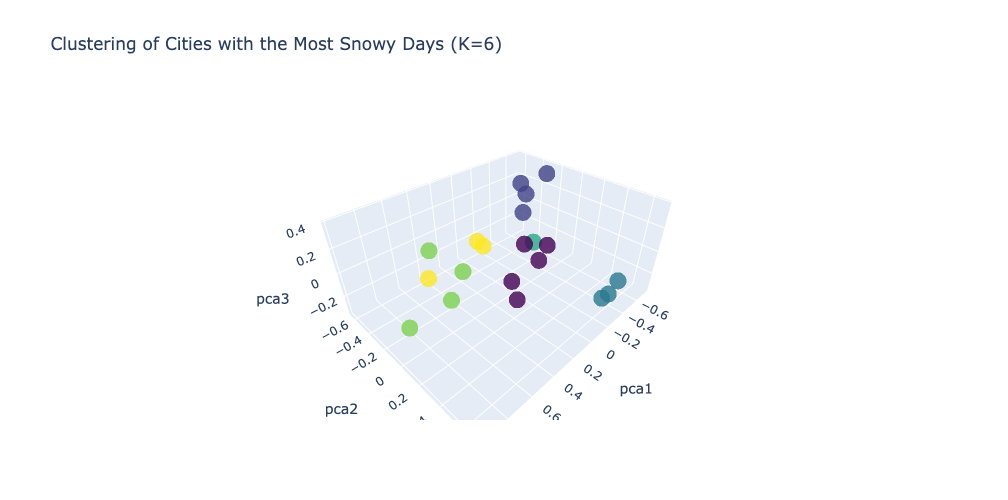

In [20]:
kmeans = KMeans(n_clusters=6)
pca_df['six_clusters'] = kmeans.fit_predict(features)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=pca_df['pca1'],
    y=pca_df['pca2'],
    z=pca_df['pca3'],
    mode='markers',
    marker=dict(
        size=10,
        color=pca_df['six_clusters'], 
        colorscale='Viridis',  
        opacity=0.8,
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='pca1',
                    yaxis_title='pca2',
                    zaxis_title='pca3'),
                  title='Clustering of Cities with the Most Snowy Days (K=6)')
fig.update_layout(height=500, width=800)
fig.show()

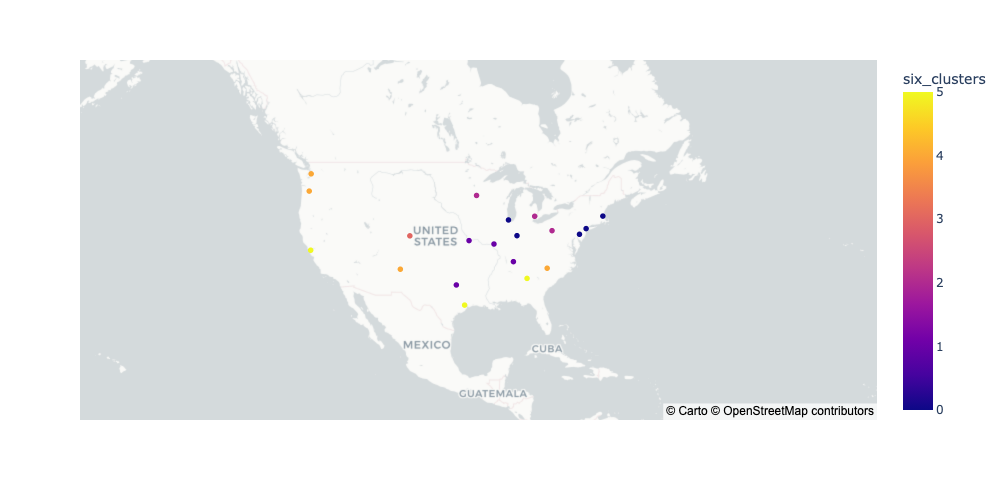

In [21]:
import plotly.express as px

fig = px.scatter_mapbox(pca_df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="six_clusters",
                        hover_name="city",
                        hover_data=hover_data_columns, 
                        mapbox_style="carto-positron",
                        zoom=2)
fig.update_layout(height=500, width=800)
fig.show()

# KMeans with number of clusters = 8

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



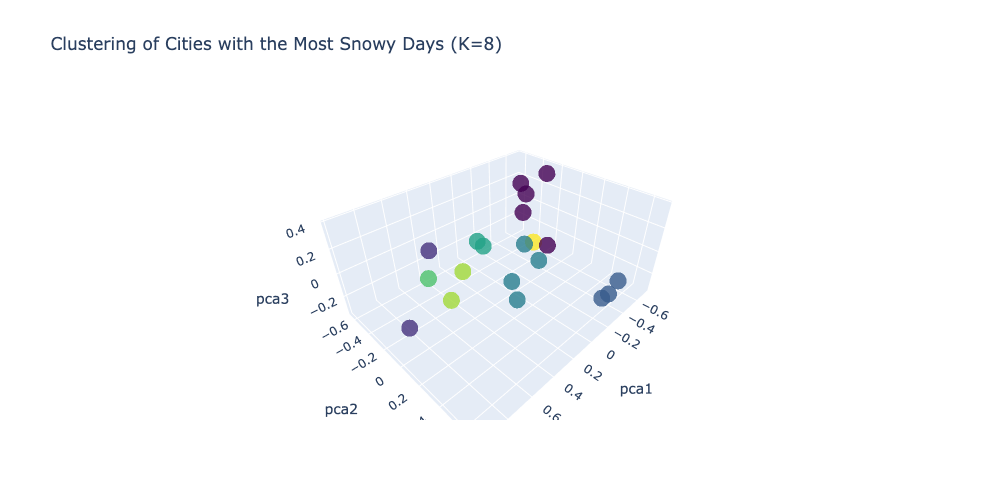

In [22]:
kmeans = KMeans(n_clusters=8)
pca_df['eight_clusters'] = kmeans.fit_predict(features)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=pca_df['pca1'],
    y=pca_df['pca2'],
    z=pca_df['pca3'],
    mode='markers',
    marker=dict(
        size=10,
        color=pca_df['eight_clusters'], 
        colorscale='Viridis',  
        opacity=0.8,
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='pca1',
                    yaxis_title='pca2',
                    zaxis_title='pca3'),
                  title='Clustering of Cities with the Most Snowy Days (K=8)')
fig.update_layout(height=500, width=800)
fig.show()

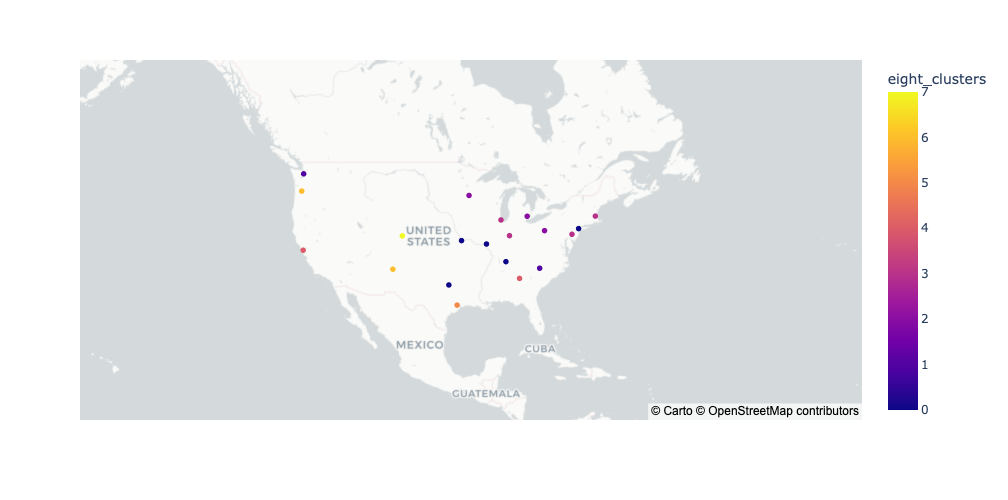

In [23]:
import plotly.express as px

fig = px.scatter_mapbox(pca_df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="eight_clusters",
                        hover_name="city",
                        hover_data=hover_data_columns, 
                        mapbox_style="carto-positron",
                        zoom=2)
fig.update_layout(height=500, width=800)
fig.show()

# KMeans with number of clusters = 4

/Users/yeshwanth/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



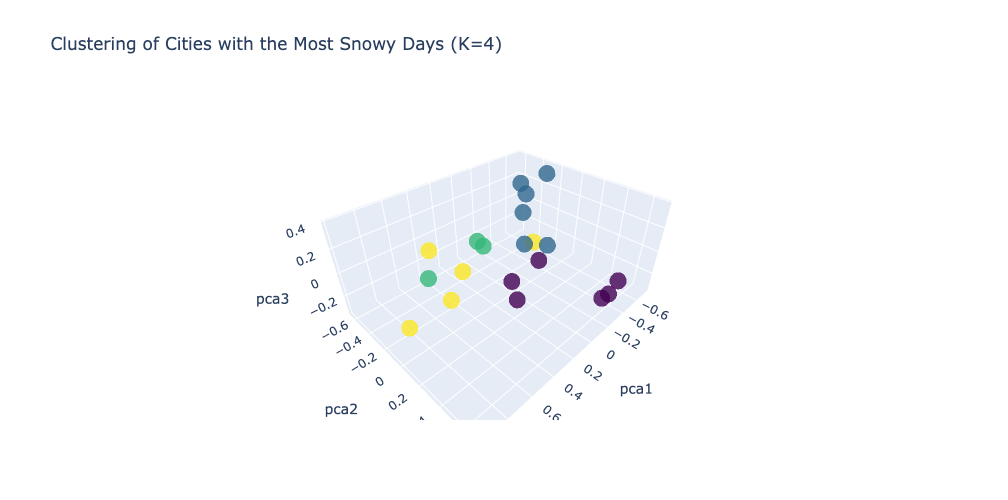

In [24]:
kmeans = KMeans(n_clusters=4)
pca_df['four_clusters'] = kmeans.fit_predict(features)

import plotly.graph_objects as go

fig = go.Figure(data=[go.Scatter3d(
    x=pca_df['pca1'],
    y=pca_df['pca2'],
    z=pca_df['pca3'],
    mode='markers',
    marker=dict(
        size=10,
        color=pca_df['four_clusters'], 
        colorscale='Viridis',  
        opacity=0.8,
    )
)])

fig.update_layout(scene=dict(
                    xaxis_title='pca1',
                    yaxis_title='pca2',
                    zaxis_title='pca3'),
                  title='Clustering of Cities with the Most Snowy Days (K=4)')
fig.update_layout(height=500, width=800)
fig.show()

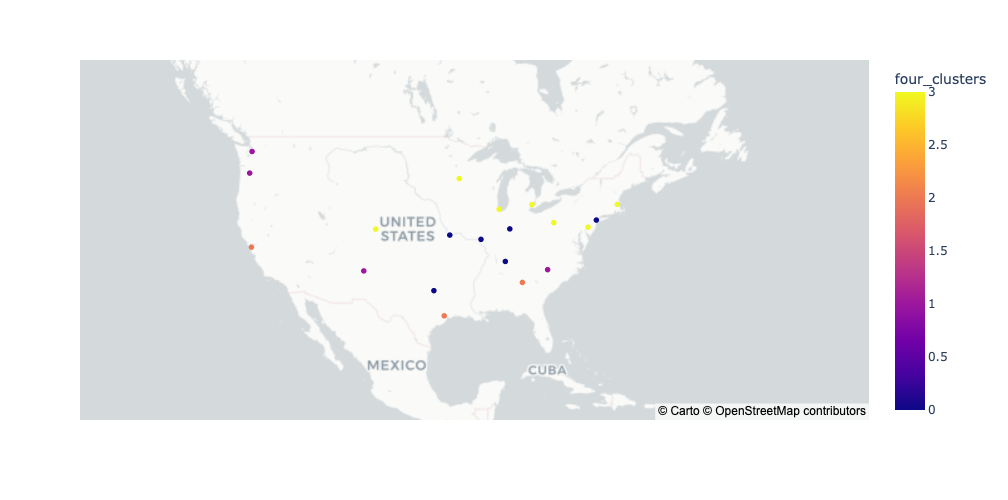

In [20]:
import plotly.express as px

fig = px.scatter_mapbox(pca_df, 
                        lat="latitude", 
                        lon="longitude", 
                        color="four_clusters",
                        hover_name="city",
                        hover_data={"snowy_weather_count": True}, 
                        mapbox_style="carto-positron",
                        zoom=2)
fig.update_layout(height=500, width=800)
fig.show()

In [22]:
cluster_0 = pca_df[pca_df['five_clusters'] == 0]
cluster_1 = pca_df[pca_df['five_clusters'] == 1]
cluster_2 = pca_df[pca_df['five_clusters'] == 2]
cluster_3 = pca_df[pca_df['five_clusters'] == 3]
cluster_4 = pca_df[pca_df['five_clusters'] == 4]

# Display cities in each cluster
print("Cities in Cluster 0:")
print(cluster_0['city'].values)
print("\nCities in Cluster 1:")
print(cluster_1['city'].values)
print("\nCities in Cluster 2:")
print(cluster_2['city'].values)
print("\nCities in Cluster 3:")
print(cluster_3['city'].values)
print("\nCities in Cluster 4:")
print(cluster_4['city'].values)

Cities in Cluster 0:
['Dallas' 'Kansas City' 'Nashville' 'New York' 'Saint Louis']

Cities in Cluster 1:
['Boston' 'Chicago' 'Denver' 'Indianapolis' 'Philadelphia']

Cities in Cluster 2:
['Albuquerque' 'Charlotte' 'Portland' 'Seattle']

Cities in Cluster 3:
['Detroit' 'Minneapolis' 'Pittsburgh']

Cities in Cluster 4:
['Atlanta' 'Houston' 'San Francisco']


In [23]:
cluster_0 = pca_df[pca_df['six_clusters'] == 0]
cluster_1 = pca_df[pca_df['six_clusters'] == 1]
cluster_2 = pca_df[pca_df['six_clusters'] == 2]
cluster_3 = pca_df[pca_df['six_clusters'] == 3]
cluster_4 = pca_df[pca_df['six_clusters'] == 4]
cluster_5 = pca_df[pca_df['six_clusters'] == 5]

# Display cities in each cluster
print("Cities in Cluster 0:")
print(cluster_0['city'].values)
print("\nCities in Cluster 1:")
print(cluster_1['city'].values)
print("\nCities in Cluster 2:")
print(cluster_2['city'].values)
print("\nCities in Cluster 3:")
print(cluster_3['city'].values)
print("\nCities in Cluster 4:")
print(cluster_4['city'].values)
print("\nCities in Cluster 5:")
print(cluster_5['city'].values)

Cities in Cluster 0:
['Detroit' 'Minneapolis' 'Pittsburgh']

Cities in Cluster 1:
['Albuquerque' 'Charlotte' 'Portland' 'Seattle']

Cities in Cluster 2:
['Dallas' 'Kansas City' 'Nashville' 'Saint Louis']

Cities in Cluster 3:
['Atlanta' 'Houston' 'San Francisco']

Cities in Cluster 4:
['Boston' 'Chicago' 'Indianapolis' 'New York' 'Philadelphia']

Cities in Cluster 5:
['Denver']
